See also: [pytorch cartpole DQN](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from tqdm import tqdm
from dataclasses import dataclass
from itertools import count
import random
import math
from typing import List, Tuple, Dict, Any, Optional, Callable, Union

In [2]:
# make env
import platoonenv
# envName = "CartPole-v0"
# envName = "MountainCar-v0"
# envName = "Acrobot-v1"

# envName = "Platoon-v0"
envName = "Platoon-v1"
# envName = "Platoon-v2"

def make_env(render_mode: Union[str, None] = None) -> gym.Env[np.ndarray, int]:
    env = gym.make(envName, render_mode=render_mode)
    return env

env = make_env()

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\gymnasium\envs\registration.py:577: UserWarning: WARN: The environment Platoon-v1 is out of date. You should consider upgrading to version `v2`.
  logger.warn(


In [3]:
print(env.observation_space)

Box(-10.0, 1.0, (20,), float32)


In [4]:
print(env.reset(seed=1))

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0., -10.,   0., -10.,   0.,   0.,   0.],
      dtype=float32), {})


In [5]:
print(env.reset())
a=env.action_space.sample(); print(env.step(a), a)
a=env.action_space.sample(); print(env.step(a), a)
a=env.action_space.sample(); print(env.step(a), a)
a=env.action_space.sample(); print(env.step(a), a)
a=env.action_space.sample(); print(env.step(a), a)
a=env.action_space.sample(); print(env.step(a), a)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,   0.],
      dtype=float32), {})
(array([  0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0., -10.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,   0.],
      dtype=float32), -9.0, False, False, {}) 5
(array([  0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0., -10.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,   0.],
      dtype=float32), -8.0, False, False, {}) 2
(array([  0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0., -10.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,   0.],
      dtype=float32), -9.0, False, False, {}) 2
(array([  0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0., -10.,
         0.,   0.,   0.,   0.,   0.,   0.,   0., -10.,   0.],
      dtype=float32), -18.0, False, False, {}) 9
(array([  0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0., -10.,
         0.,   0.,   0.,   

In [6]:
obs=env.reset()[0]
actions = np.arange(1,11)[obs[10:]!=-10].tolist() + [0,0]
print(sum(env.step(x)[1] for x in actions))

-48.0


In [7]:
a = env.reset(seed=1)[0]
b = env.reset(seed=1)[0]
c = env.reset(seed=2)[0]
assert np.array_equal(a.flatten(),b.flatten()), "env should respect reset seed"
assert envName == "Platoon-v0" or not np.array_equal(b,c), "env should respect reset seed"

In [8]:
print(env.action_space)
print(env.action_space.n)
print(env.action_space.sample())

Discrete(11)
11
9


In [9]:
print(env.spec.reward_threshold)

-48


In [10]:
class DQN(nn.Module):
    def __init__(self, obs_shape: Tuple[int,...], hidden_shapes: Tuple[int,...], num_actions: int):
        super().__init__()
        assert len(hidden_shapes) > 0
        net = []
        obs_shape_flat = math.prod(obs_shape)
        shapes = (obs_shape_flat, ) + hidden_shapes
        for i in range(1, len(shapes)):
            net.append(nn.Linear(shapes[i-1], shapes[i]))
            net.append(nn.BatchNorm1d(shapes[i]))
            net.append(nn.ReLU())
        self.final = nn.Linear(hidden_shapes[-1] + obs_shape_flat, num_actions)
        self.net = nn.Sequential(*net)

    def forward(self, x: Tensor) -> Tensor:
        x = x.flatten(start_dim=1)
        temp = x
        x = self.net(x)
        x = self.final(torch.cat((x, temp), dim=1))
        return x

In [11]:
# instantiate models
assert env.observation_space.shape is not None
assert env.action_space.n is not None # type: ignore
HIDDEN_SHAPES = (128,128,128,128)
# HIDDEN_SHAPES = (256,256,256,256,256,256)
# HIDDEN_SHAPES = (512,512,512,512)
policy = DQN(
    obs_shape = env.observation_space.shape,
    hidden_shapes = HIDDEN_SHAPES,
    num_actions = env.action_space.n, # type: ignore
)
policy_target = DQN(
    obs_shape = env.observation_space.shape,
    hidden_shapes = HIDDEN_SHAPES,
    num_actions = env.action_space.n, # type: ignore
)
policy_target.eval()
print(policy)

DQN(
  (final): Linear(in_features=148, out_features=11, bias=True)
  (net): Sequential(
    (0): Linear(in_features=20, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
  )
)


In [12]:
# weight update functions
# from https://github.com/ghliu/pytorch-ddpg/blob/master/util.py#L26
def soft_update(target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            ## shouldn't be necessary since we use target networks to calculate loss
            # if isinstance(target_param, torch.nn.parameter.UninitializedParameter):
            #     # target model uninitialized, hard update
            #     target_param.data.copy_(param.data)
            # else:
            target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

def hard_update(target, source):
    target.load_state_dict(source.state_dict())
    # for target_param, param in zip(target.parameters(), source.parameters()):
    #         target_param.data.copy_(param.data)

In [13]:
hard_update(policy_target, policy)

In [14]:
@dataclass
class Transition:
    observation: Tensor
    action: int
    reward: float
    next_observation: Tensor
    finished: bool

@dataclass
class TransitionBatch:
    observations: Tensor
    actions: Tensor
    rewards: Tensor
    next_observations: Tensor
    finished: Tensor
    indices: Tensor
    priorities: Tensor
    weights: Tensor

In [15]:
class PrioritizedReplayBuffer:
    def __init__(
        self,
        capacity: int,
        alpha: float,
        beta: float,
        epsilon: float,
    ):
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta
        self.epsilon = epsilon
        from sumtree import SumTree
        self.tree = SumTree(capacity)
        self.transitions: List[Union[None, Transition]] = [None for _ in range(capacity)]
        self.current_index = 0
        self.len = 0
    
    def append(self, transition: Transition):
        # from the paper: New transitions arrive without a known TD-error,
        # so we put them at maximal priority in order to guarantee that 
        # all experience is seen at least once.
        priority = 1000 + self.epsilon
        self.tree.update(self.current_index, priority) # type: ignore
        self.transitions[self.current_index] = transition
        self.current_index = (self.current_index + 1) % self.capacity
        self.len = min(self.len + 1, self.capacity)

    def update(self, indices: List[int], priorities: List[float]):
        # from the paper: The TD-error is updated after each minibatch 
        # update, and the priorities are updated accordingly.
        for i, p in zip(indices, priorities):
            self.tree.update(i, (p + self.epsilon) ** self.alpha) # type: ignore

    def sample(self, batch_size: int) -> TransitionBatch:
        # from the paper:
        # The ‘sum-tree’ data structure used here is very similar in spirit to the 
        # array representation of a binary heap. This provides a efficient way of
        # calculating the cumulative sum of priorities, allowing O(logN) 
        # updates and sampling. To sample a minibatch of size k, the 
        # range [0; ptotal] is divided equally into k ranges. Next, a 
        # value is uniformly sampled from each range. Finally the transitions 
        # that correspond to each of these sampled values are retrieved from 
        # the tree. Overhead is similar to rank-based prioritization.
        indices = []
        priorities = []
        transitions = []
        # split the tree into batch_size+1 segments
        space = torch.linspace(0, self.tree.total, batch_size+1).tolist()
        # treat the segments as ranges
        ranges = torch.as_tensor(list(zip(space[:-1], space[1:])))
        # sample a random number in each range
        rand = torch.rand(batch_size)
        cumsums = (ranges[:,0] + (ranges[:,1]-ranges[:,0])*rand).tolist()
        # get the transition corresponding to each random number
        for x in cumsums:
            index, priority = self.tree.get(x)
            trans = self.transitions[index]
            if trans is None:
                index, priority, trans = indices[0], priorities[0], transitions[0]
            indices.append(index)
            priorities.append(priority)
            # use assert to silence python type warnings
            transitions.append(trans)

        # from the paper:
        # P(i) = p_i^alpha / sum_k{p_k^alpha}
        # where p_i = |TD-error| + epsilon
        priorities = torch.as_tensor(priorities, dtype=torch.float32)
        probabilities = priorities / (self.tree.total)
        # Computes the importance sampling (IS) weights for each transition in the batch based on the priorities.
        weights = (self.capacity * probabilities) ** (-self.beta)
        weights /= weights.max()

        return TransitionBatch(
            observations=torch.stack([x.observation for x in transitions]),
            actions=torch.as_tensor([x.action for x in transitions], dtype=torch.int64),
            rewards=torch.as_tensor([x.reward for x in transitions], dtype=torch.float32),
            next_observations=torch.stack([x.next_observation for x in transitions]),
            finished=torch.as_tensor([x.finished for x in transitions], dtype=torch.bool),
            indices=torch.as_tensor(indices, dtype=torch.int64),
            priorities=torch.as_tensor(priorities, dtype=torch.float32),
            weights=weights,
        )

    def __len__(self) -> int:
        return self.len

In [16]:
class DequeReplayBuffer:
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    
    def append(self, transition: Transition):
        self.buffer.append(transition)
    
    def sample(self, batch_size: int) -> TransitionBatch:
        transitions = random.sample(self.buffer, batch_size)
        return TransitionBatch(
            observations=torch.stack([x.observation for x in transitions]),
            actions=torch.as_tensor([x.action for x in transitions], dtype=torch.int64),
            rewards=torch.as_tensor([x.reward for x in transitions], dtype=torch.float32),
            next_observations=torch.stack([x.next_observation for x in transitions]),
            finished=torch.as_tensor([x.finished for x in transitions], dtype=torch.bool),
            indices=None,
            priorities=None,
            weights=None,
        )

    def __len__(self) -> int:
        return len(self.buffer)


In [17]:
MEMORY_SIZE = 10000
# MEMORY_SIZE = 10_000_000
# MEMORY_TYPE = "prioritized"
MEMORY_TYPE = "deque"
if MEMORY_TYPE == "prioritized":
    memory = PrioritizedReplayBuffer(
        capacity=MEMORY_SIZE,
        alpha=0.6,
        beta=0.4,
        epsilon=0.01,
    )
elif MEMORY_TYPE == "deque":
    memory = DequeReplayBuffer(MEMORY_SIZE)
else:
    raise Exception("bad type")

In [18]:
def get_exploration_epsilon(steps_done: int) -> float:
    EPSILON_START = 0.9
    EPSILON_END = 0.05
    EPSILON_DECAY = 1000
    return EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY)

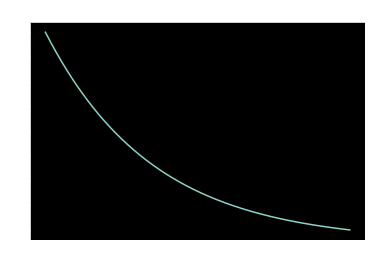

In [19]:
# plot epsilon
# %matplotlib ipympl
%matplotlib inline
plt.figure()
plt.style.use('dark_background')
plt.title("exploration epsilon")
plt.plot([get_exploration_epsilon(i) for i in range(1000000) if get_exploration_epsilon(i) >= 0.1])
plt.show()

In [20]:
def get_action(obs: Tensor, epsilon: float) -> int:
    if random.random() < epsilon:
        return env.action_space.sample()
    state_batch = obs.unsqueeze(0)
    policy.eval()
    with torch.no_grad():
        q_values = policy(state_batch)
    return int(q_values.argmax(dim=1).squeeze()) # return action with highest q-value

In [21]:
def test(render=False, seed:int=42) -> Tuple[bool, float]:
    if render:
        env = make_env(render_mode="human")
    else:
        env = make_env()
    assert env.spec is not None
    assert env.spec.reward_threshold is not None
    obs, info = env.reset(seed=seed)
    obs = torch.as_tensor(obs, dtype=torch.float32)
    episode_reward = 0.0
    for i in count():
        action = get_action(obs, 0)
        obs, reward, done, trunc, info = env.step(action)
        obs = torch.as_tensor(obs, dtype=torch.float32)
        episode_reward += float(reward)
        if render:
            env.render()
        if done or trunc:
            break
    return episode_reward >= env.spec.reward_threshold, episode_reward

In [22]:
assert not test()[0], "untrained model should probably not be able to solve the environment"
assert np.array_equal(test()[1], test()[1]), "tests should be performed with the same seed"

c:\Users\TeamD\.conda\envs\subgame\lib\site-packages\gymnasium\envs\registration.py:577: UserWarning: WARN: The environment Platoon-v1 is out of date. You should consider upgrading to version `v2`.
  logger.warn(


In [23]:
# step metrics
loss_history: List[float] = []
learning_rate_history: List[float] = []
reward_history: List[float] = []
duration_history: List[int] = []
action_history: List[int] = []
terminal_history: List[bool] = []
# other metrics
test_reward_history: List[Tuple[int, float, float]] = []
last_episode_reward = 0

In [24]:
optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)
# optimizer = torch.optim.Adam(policy.parameters(), lr=0.001)
# optimizer = torch.optim.RMSprop(policy.parameters(), lr=LEARNING_RATE)

In [25]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    # mode="max",
    mode="min",
    factor=0.9,
    patience=5000,
    cooldown=5000,
    min_lr=0.00001,
    verbose=True,
)

In [26]:
# %load_ext scalene
# use %%scalene to profile a cell


In [27]:
steps_done = 0

In [37]:
# train loop
TRAIN_EPISODES = 600
PREVIEW_EPISODE_INTERVAL = 0 # 30
BATCH_SIZE = 1280
REWARD_GAMMA = 0.99
TEST_INTERVAL = 200
SOFT_UPDATE_TAU = 0.001  
POLICY_TARGET_UPDATE_INTERVAL = 250

# TRAIN_EPISODES = 100000
solved = False
warmup_steps = BATCH_SIZE + 4

with tqdm(total=TRAIN_EPISODES, dynamic_ncols=True, ascii=True) as pbar:
    for episode in range(TRAIN_EPISODES):
        if solved: break
        
        warmup = steps_done < warmup_steps
        should_preview = not warmup and PREVIEW_EPISODE_INTERVAL > 0 and episode % PREVIEW_EPISODE_INTERVAL == 0
        
        obs = torch.as_tensor(env.reset(seed=random.randint(0,100000))[0], dtype=torch.float32)

        episode_reward = 0.0

        for episode_step in count():
            epsilon = 1 if warmup else 0 if should_preview else get_exploration_epsilon(steps_done-warmup_steps)
            #region exploration
            action = get_action(obs, epsilon)
            action_history.append(action)
            next_obs, reward, done, trunc, info = env.step(action)
            reward = float(reward)
            episode_reward += reward
            reward_history.append(reward)
            terminal_history.append(done)
            if done or trunc:
                duration_history.append(episode_step)
                next_obs = torch.zeros(obs.shape)
            else:
                next_obs = torch.as_tensor(next_obs, dtype=torch.float32)                
            memory.append(Transition(
                observation=obs,
                action=action,
                reward=reward,
                next_observation=next_obs,
                finished=done or trunc,
            ))
            obs = next_obs
            if should_preview:
                env.render()
            #endregion exploration

            #region training
            if warmup:
                pbar.set_description(f"warmup")
            else:
                policy.train()
                batch = memory.sample(BATCH_SIZE)

                # calculate q values for the actions that were taken
                q_pred = policy(batch.observations).gather(1, batch.actions.unsqueeze(1))

                # calculate q values for next state
                q_next = torch.zeros(BATCH_SIZE)
                non_final = ~batch.finished
                q_next[non_final] = policy_target(batch.next_observations[non_final]).max(dim=1).values.detach()

                # calculate expected q values
                q_expected = ((q_next * REWARD_GAMMA) + batch.rewards).unsqueeze(1)

                # calculate loss
                # criterion = torch.nn.SmoothL1Loss()
                # criterion = torch.nn.MSELoss()
                policy_loss = F.mse_loss(q_pred, q_expected)

                if isinstance(memory, PrioritizedReplayBuffer):
                    td_error = (q_expected - q_pred).abs().detach().flatten().tolist()
                    indices = batch.indices.tolist()
                    # update replay buffer priorities
                    memory.update(indices, td_error)
                    # scale loss by weights
                    policy_loss = (batch.weights * policy_loss).mean()


                loss_history.append(policy_loss.item())

                # apply weight update
                optimizer.zero_grad()
                policy_loss.backward()
                # for param in policy.parameters():
                #     assert param.grad is not None
                #     param.grad.data.clamp_(-1, 1) 
                optimizer.step()
                
                # update learning rate
                lr = optimizer.param_groups[0]["lr"]
                learning_rate_history.append(lr)
                scheduler.step(policy_loss)

                ## update target network
                
                # soft_update(policy_target, policy, SOFT_UPDATE_TAU)
                if steps_done % POLICY_TARGET_UPDATE_INTERVAL == 0:
                    hard_update(policy_target, policy)

                #region testing
                if steps_done % TEST_INTERVAL == 0:
                    tests = list(zip(*[test() for _ in range(5)]))
                    test_passes: List[bool] = tests[0] # type: ignore :P
                    test_rewards: List[float] = tests[1] # type: ignore :P
                    passed = all(test_passes)
                    test_reward_mean = np.mean(test_rewards).item()
                    test_reward_variance = max(max(test_rewards) - test_reward_mean, test_reward_mean - min(test_rewards))

                    test_reward_history.append((steps_done, test_reward_mean, test_reward_variance))

                    best = max(test_reward_history, key=lambda x: x[1] - x[2])

                    test_reward = f"{test_reward_mean:.3f} \u00b1 {test_reward_variance:.3f}"
                    best_reward = f"{best[1]:.3f} \u00b1 {best[2]:.3f}"
                    print(f"test reward: {test_reward} (best: {best_reward}, goal: {env.spec.reward_threshold})")
                    last_test_reward = test_reward
                    if passed:
                        print("solved!")
                        solved=True
                        break
                #endregion testing

                pbar.set_description(f"policy: {policy_loss.item():09.3f}, reward: {reward:+07.3f} (last episode: {last_episode_reward:.3f}), epsilon: {epsilon:.3f}, lr: {lr:.7f}, steps: {steps_done}")
            #endregion training

            steps_done += 1

            if done or trunc: break

        last_episode_reward = episode_reward
        pbar.update()

policy: 00017.962, reward: -05.000 (last episode: -59.000), epsilon: 0.050, lr: 0.0009000, steps: 13204:   0%|          | 0/600 [00:00<?, ?it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00019.812, reward: -05.000 (last episode: -65.000), epsilon: 0.050, lr: 0.0009000, steps: 13408:   3%|3         | 18/600 [00:05<02:26,  3.96it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00012.794, reward: -08.000 (last episode: -56.000), epsilon: 0.050, lr: 0.0009000, steps: 13608:   6%|6         | 37/600 [00:09<02:25,  3.87it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00022.315, reward: -05.000 (last episode: -56.000), epsilon: 0.050, lr: 0.0009000, steps: 13809:   9%|9         | 55/600 [00:14<02:18,  3.94it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00019.075, reward: -03.000 (last episode: -56.000), epsilon: 0.050, lr: 0.0009000, steps: 14009:  12%|#2        | 73/600 [00:18<02:04,  4.25it/s] 

test reward: -62.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00015.838, reward: -04.000 (last episode: -56.000), epsilon: 0.050, lr: 0.0009000, steps: 14209:  15%|#5        | 91/600 [00:22<01:59,  4.26it/s]

test reward: -54.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00017.426, reward: -09.000 (last episode: -82.000), epsilon: 0.050, lr: 0.0009000, steps: 14410:  18%|#8        | 110/600 [00:26<01:51,  4.40it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00016.436, reward: -08.000 (last episode: -68.000), epsilon: 0.050, lr: 0.0009000, steps: 14609:  21%|##1       | 128/600 [00:30<01:50,  4.25it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00016.002, reward: -07.000 (last episode: -50.000), epsilon: 0.050, lr: 0.0009000, steps: 14808:  24%|##4       | 146/600 [00:34<01:45,  4.29it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00016.442, reward: -04.000 (last episode: -56.000), epsilon: 0.050, lr: 0.0009000, steps: 15009:  27%|##7       | 164/600 [00:38<01:40,  4.33it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00015.737, reward: -04.000 (last episode: -135.000), epsilon: 0.050, lr: 0.0009000, steps: 15207:  30%|###       | 182/600 [00:43<01:46,  3.94it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00014.699, reward: -04.000 (last episode: -152.000), epsilon: 0.050, lr: 0.0009000, steps: 15409:  33%|###3      | 200/600 [00:47<01:34,  4.23it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00013.080, reward: -09.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0009000, steps: 15609:  36%|###6      | 219/600 [00:52<01:37,  3.91it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00015.345, reward: -07.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0009000, steps: 15809:  40%|###9      | 237/600 [00:56<01:27,  4.17it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00017.369, reward: -04.000 (last episode: -56.000), epsilon: 0.050, lr: 0.0009000, steps: 16010:  42%|####2     | 255/600 [01:00<01:17,  4.45it/s] 

test reward: -54.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00012.867, reward: -03.000 (last episode: -55.000), epsilon: 0.050, lr: 0.0009000, steps: 16209:  46%|####5     | 273/600 [01:04<01:16,  4.26it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00014.172, reward: -12.000 (last episode: -54.000), epsilon: 0.050, lr: 0.0009000, steps: 16409:  48%|####8     | 291/600 [01:08<01:10,  4.41it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00014.642, reward: -09.000 (last episode: -65.000), epsilon: 0.050, lr: 0.0008100, steps: 16500:  50%|#####     | 300/600 [01:10<01:06,  4.48it/s] 

Epoch 15205: reducing learning rate of group 0 to 8.1000e-04.


policy: 00014.074, reward: -13.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0008100, steps: 16609:  52%|#####1    | 309/600 [01:12<01:04,  4.51it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00013.836, reward: -07.000 (last episode: -53.000), epsilon: 0.050, lr: 0.0008100, steps: 16810:  55%|#####4    | 328/600 [01:16<01:01,  4.43it/s] 

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00013.806, reward: -06.000 (last episode: -162.000), epsilon: 0.050, lr: 0.0008100, steps: 17009:  58%|#####7    | 346/600 [01:20<00:57,  4.42it/s]

test reward: -56.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00012.253, reward: -03.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0008100, steps: 17210:  61%|######    | 364/600 [01:24<00:53,  4.44it/s] 

test reward: -62.000 ± 0.000 (best: -54.000 ± 0.000, goal: -48)


policy: 00012.067, reward: -05.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0008100, steps: 17409:  64%|######3   | 382/600 [01:29<00:49,  4.40it/s]

test reward: -52.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00013.887, reward: -03.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0008100, steps: 17609:  67%|######6   | 400/600 [01:33<00:44,  4.49it/s] 

test reward: -52.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00013.674, reward: -08.000 (last episode: -132.000), epsilon: 0.050, lr: 0.0008100, steps: 17810:  70%|######9   | 419/600 [01:37<00:41,  4.39it/s]

test reward: -52.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00011.671, reward: -06.000 (last episode: -56.000), epsilon: 0.050, lr: 0.0008100, steps: 18010:  73%|#######2  | 437/600 [01:41<00:37,  4.39it/s] 

test reward: -52.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00010.415, reward: -05.000 (last episode: -55.000), epsilon: 0.050, lr: 0.0008100, steps: 18209:  76%|#######5  | 455/600 [01:45<00:34,  4.19it/s] 

test reward: -52.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00013.289, reward: -03.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0008100, steps: 18409:  79%|#######8  | 473/600 [01:49<00:29,  4.35it/s]

test reward: -52.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00012.258, reward: -03.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0008100, steps: 18610:  82%|########1 | 491/600 [01:53<00:24,  4.40it/s]

test reward: -54.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00011.334, reward: -03.000 (last episode: -52.000), epsilon: 0.050, lr: 0.0008100, steps: 18809:  85%|########4 | 509/600 [01:57<00:20,  4.53it/s] 

test reward: -54.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00011.202, reward: -07.000 (last episode: -50.000), epsilon: 0.050, lr: 0.0008100, steps: 19010:  88%|########8 | 528/600 [02:01<00:16,  4.38it/s]

test reward: -52.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00010.199, reward: -05.000 (last episode: -72.000), epsilon: 0.050, lr: 0.0008100, steps: 19210:  91%|#########1| 546/600 [02:05<00:11,  4.67it/s] 

test reward: -65.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00009.542, reward: -07.000 (last episode: -134.000), epsilon: 0.050, lr: 0.0008100, steps: 19408:  94%|#########3| 564/600 [02:09<00:07,  4.76it/s]

test reward: -65.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00009.298, reward: -03.000 (last episode: -62.000), epsilon: 0.050, lr: 0.0008100, steps: 19608:  97%|#########7| 582/600 [02:14<00:04,  4.11it/s] 

test reward: -65.000 ± 0.000 (best: -52.000 ± 0.000, goal: -48)


policy: 00011.780, reward: -02.000 (last episode: -58.000), epsilon: 0.050, lr: 0.0008100, steps: 19799: 100%|##########| 600/600 [02:18<00:00,  4.35it/s]


In [29]:
batch = memory.sample(10)
print("observations", batch.observations)
print("next_observations", batch.next_observations)
print("finished", batch.finished)
print("actions", batch.actions)
print("rewards", batch.rewards)
print("indices", batch.indices)
print("priorities", batch.priorities)
print("weights", batch.weights)

observations tensor([[  1.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,   0., -10.,
           0.,   0.,   0.,   0.,   0.,   0., -10.,   0.],
        [  0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1., -10.,   0.,
           0.,   0.,   0.,   0.,   0.,   0., -10.,   0.],
        [  1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
         -10.,   0.,   0.,   0.,   0., -10.,   0.,   0.],
        [  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0., -10.,
           0.,   0.,   0., -10.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,   1.,   0., -10.,
           0., -10.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  1.,   1.,   1.,   1.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
           0.,   0.,   0.,   0., -10., -10.,   0.,   0.],
        [  1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   1.,   0., -10.,   0.,
           0.,   0., -10.,   0.,   0.,   0.,   0.,   0.],
        [  0.,

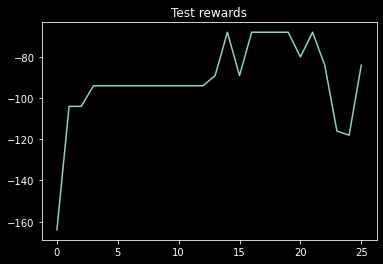

In [30]:
# plot rewards
plt.figure()
plt.plot([x[1]-x[2] for x in test_reward_history])
plt.title("Test rewards")
plt.show()

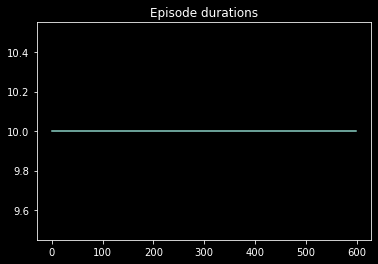

In [31]:
# plot durations
plt.figure()
plt.plot(duration_history)
plt.title("Episode durations")
plt.show()

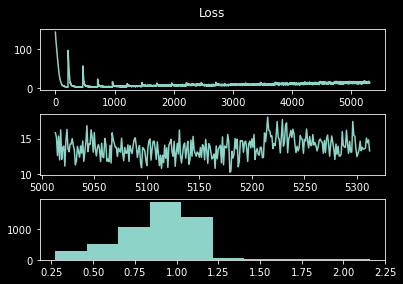

In [32]:
# plot loss
fig, axs = plt.subplots(3)
plt.subplots_adjust(
    left=0.1,
    bottom=0.1,
    right=0.9,
    top=0.9,
    # wspace=0.4,
    hspace=0.4,
)
fig.suptitle("Loss")
axs[0].plot(loss_history)
axs[1].plot(range(len(loss_history))[-300:], loss_history[-300:])
axs[2].hist(np.log10(loss_history))
plt.show()

In [33]:
# investigate actions
import ipywidgets as widgets
plt.figure()
# @widgets.interact(i=(0, len(action_history)-1), window_size=(1, len(action_history)-1))
@widgets.interact(i=(0, len(action_history)-1), window_size=(1, 1000))
def preview_actions(i=len(action_history)-100, window_size=72):
    x = torch.zeros((len(action_history), env.action_space.n + 1))
    x[range(len(action_history)), action_history] = 1
    x[:, 2] = torch.as_tensor(terminal_history, dtype=torch.bool)
    plt.imshow(x[i:i+window_size], aspect="auto")
    plt.show()
    del x

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=6500, description='i', max=6599), IntSlider(value=72, description='windo…

In [34]:
obs, info = env.reset()
obs = torch.as_tensor(obs, dtype=torch.float32)
episode_reward = 0.0
for i in count():
    action = get_action(obs, 0)
    obs, reward, done, trunc, info = env.step(action)
    print(action, obs, reward)
    obs = torch.as_tensor(obs, dtype=torch.float32)
    episode_reward += float(reward)
    # if render:
    #     env.render()
    if done or trunc:
        break
print(episode_reward)

3 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -9.0
9 [  0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -8.0
5 [  0.   0.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -7.0
9 [  0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -8.0
9 [  0.   0.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -7.0
9 [  0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -8.0
9 [  0.   0.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -7.0
9 [  0.   0.   1.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -8.0
9 [  0.   0.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0. -10.
   0.   0.   0. -10.   0.   0.] -7.0
9 [  0.   

In [35]:
# preview
epsilon = 0
for episode in range(5):
    success, reward = test(render=False)
    print(f"success={success}, reward={reward}")

success=False, reward=-89.0
success=False, reward=-89.0
success=False, reward=-89.0
success=False, reward=-89.0
success=False, reward=-89.0


- security metrics
    - investigate paper: "Deep Reinforcement Learning-Based Defense Strategy Selection"
- why DQN over other algorithms; does it reflect our real world scenario
- plan: results early-mid january